In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from model import GeoVictoria
import ast

In [7]:
def get_data(problem, replicates, max_steps, distinct_samples):
    # Set the outputs
    model_reporters = {"Population": lambda m: [a.population for a in m.space.agents]}

    data = {}

    for i, var in enumerate(problem['names']):
        # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
        
        # Keep in mind that wolf_gain_from_food should be integers. You will have to change
        # your code to acommodate for this or sample in such a way that you only get integers.
        # if var == 'wolf_gain_from_food':
        #     samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
        
        batch = BatchRunner(GeoVictoria, 
                            max_steps=max_steps,
                            iterations=replicates,
                            variable_parameters={var: samples},
                            model_reporters=model_reporters,
                            display_progress=True)
        
        batch.run_all()
        
        data[var] = batch.get_model_vars_dataframe()
    
    return data

def get_data_sobol(problem, replicates, max_steps, distinct_samples):
    model_reporters = {"Population": lambda m: [a.population for a in m.space.agents]}
    
    # We get all our samples here
    param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)

    # READ NOTE BELOW CODE
    batch = BatchRunner(GeoVictoria, 
                        max_steps=max_steps,
                        variable_parameters={name:[] for name in problem['names']},
                        model_reporters=model_reporters)

    count = 0
    data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                    columns=['stoch', 'alpha', 'beta', 'gamma'])
    data['Run'], data['Population'] = None, None

    for i in range(replicates):
        for vals in param_values: 
            # Change parameters that should be integers
            vals = list(vals)
            vals[2] = int(vals[2])
            # Transform to dict with parameter names and their values
            variable_parameters = {}
            for name, val in zip(problem['names'], vals):
                variable_parameters[name] = val

            batch.run_iteration(variable_parameters, tuple(vals), count)
            iteration_data = batch.get_model_vars_dataframe().iloc[count]
            iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
            print(data)
            data.iloc[count, 0:4] = vals
            data.iloc[count, 4:8] = iteration_data
            print(data)
            count += 1

            # clear_output()
            print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    
    return data

def read_data(problem, convert=True):
    data = dict()
    for var in problem['names']:
        data[var] = pd.read_csv(f'Data/SA_data_{var}.csv', converters={'Population':ast.literal_eval})
        if convert:
            # print(data[var]['Population'].iloc[0])
            data[var]['gini'] = [gini(np.array(data[var]['Population'].iloc[i])) for i in range(len(data[var]['Population']))]

    return data

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [8]:
# We define our variables and bounds
problem = {
    'num_vars': 4,
    'names': ['stoch', 'alpha', 'beta', 'gamma'],
    'bounds': [[0.5, 1], [1.5, 2.5], [0.1, 0.3], [0.001, 0.005]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 10
distinct_samples = 2

# Get data for OFAT
# data = get_data(problem, replicates, max_steps, distinct_samples)
# Get data for SOBOL
data = get_data_sobol(problem, replicates, max_steps, distinct_samples)

/tmp/ipykernel_10108/693370659.py:33: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)
/tmp/ipykernel_10108/693370659.py:36: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch = BatchRunner(GeoVictoria,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   stoch alpha beta gamma   Run Population
0    NaN   NaN  NaN   NaN  None       None
1    NaN   NaN  NaN   NaN  None       None
2    NaN   NaN  NaN   NaN  None       None
3    NaN   NaN  NaN   NaN  None       None
4    NaN   NaN  NaN   NaN  None       None
5    NaN   NaN  NaN   NaN  None       None
6    NaN   NaN  NaN   NaN  None       None
7    NaN   NaN  NaN   NaN  None       None
8    NaN   NaN  NaN   NaN  None       None
9    NaN   NaN  NaN   NaN  None       None
10   NaN   NaN  NaN   NaN  None       None
11   NaN   NaN  NaN   NaN  None       None
12   NaN   NaN  NaN   NaN  None       None
13   NaN   NaN  NaN   NaN  None       None
14   NaN   NaN  NaN   NaN  None       None
15   NaN   NaN  NaN   NaN  None       None
16   NaN   NaN  NaN   NaN  None       None
17   NaN   NaN  NaN   NaN  None       None
18   NaN   NaN  NaN   NaN  None       None
19   NaN   NaN  NaN   NaN  None       None
20   NaN   NaN  NaN   NaN  None       None
21   NaN   NaN  NaN   NaN  None       None
22   NaN   

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1        NaN      NaN  NaN       NaN  None   
2        NaN      NaN  NaN       NaN  None   
3        NaN      NaN  NaN       NaN  None   
4        NaN      NaN  NaN       NaN  None   
5        NaN      NaN  NaN       NaN  None   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2        NaN      NaN  NaN       NaN  None   
3        NaN      NaN  NaN       NaN  None   
4        NaN      NaN  NaN       NaN  None   
5        NaN      NaN  NaN       NaN  None   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3        NaN      NaN  NaN       NaN  None   
4        NaN      NaN  NaN       NaN  None   
5        NaN      NaN  NaN       NaN  None   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4        NaN      NaN  NaN       NaN  None   
5        NaN      NaN  NaN       NaN  None   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5        NaN      NaN  NaN       NaN  None   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6        NaN      NaN  NaN       NaN  None   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7        NaN      NaN  NaN       NaN  None   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8        NaN      NaN  NaN       NaN  None   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9        NaN      NaN  NaN       NaN  None   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10       NaN      NaN  NaN       NaN  None   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11       NaN      NaN  NaN       NaN  None   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12       NaN      NaN  NaN       NaN  None   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13       NaN      NaN  NaN       NaN  None   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14       NaN      NaN  NaN       NaN  None   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15       NaN      NaN  NaN       NaN  None   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16       NaN      NaN  NaN       NaN  None   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17       NaN      NaN  NaN       NaN  None   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18       NaN      NaN  NaN       NaN  None   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18  0.796875  2.46875    0  0.001625    18   
19       NaN      NaN  NaN       NaN  None   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18  0.796875  2.46875    0  0.001625    18   
19  0.890625  2.46875    0  0.001625    19   
20       NaN      NaN  NaN       N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18  0.796875  2.46875    0  0.001625    18   
19  0.890625  2.46875    0  0.001625    19   
20  0.796875  1.96875    0  0.0016

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18  0.796875  2.46875    0  0.001625    18   
19  0.890625  2.46875    0  0.001625    19   
20  0.796875  1.96875    0  0.0016

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


       stoch    alpha beta     gamma   Run  \
0   0.546875  1.96875    0  0.003625     0   
1   0.640625  1.96875    0  0.003625     1   
2   0.546875  2.46875    0  0.003625     2   
3   0.546875  1.96875    0  0.003625     3   
4   0.546875  1.96875    0  0.004375     4   
5   0.640625  2.46875    0  0.004375     5   
6   0.796875  2.46875    0  0.001625     6   
7   0.890625  2.46875    0  0.001625     7   
8   0.796875  1.96875    0  0.001625     8   
9   0.796875  2.46875    0  0.001625     9   
10  0.796875  2.46875    0  0.002375    10   
11  0.890625  1.96875    0  0.002375    11   
12  0.546875  1.96875    0  0.003625    12   
13  0.640625  1.96875    0  0.003625    13   
14  0.546875  2.46875    0  0.003625    14   
15  0.546875  1.96875    0  0.003625    15   
16  0.546875  1.96875    0  0.004375    16   
17  0.640625  2.46875    0  0.004375    17   
18  0.796875  2.46875    0  0.001625    18   
19  0.890625  2.46875    0  0.001625    19   
20  0.796875  1.96875    0  0.0016

In [15]:
data['gini'] = [gini(np.array(p)) for p in data['Population']]

In [17]:
Si_pop = sobol.analyze(problem, data['gini'].values, print_to_console=True, calc_second_order=False)

             ST   ST_conf
stoch  0.699184  3.732371
alpha  0.662882  3.616769
beta   0.662882  3.616769
gamma  0.662882  3.616769
             S1   S1_conf
stoch -0.499578  2.786566
alpha -0.488285  2.751566
beta  -0.488285  2.751566
gamma -0.488285  2.751566


In [18]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    # print(df)
    x = df[var].groupby(var).mean().reset_index()[var]
    y = df[var].groupby(var).mean()[param]

    replicates = df[var].groupby(var)[param].count()
    err = (1.96 * df[var].groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param, problem):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(4, figsize=(7, 15))
    
    for i, var in enumerate(problem['names']):
        # print(i, var, df[var])
        plot_param_var_conf(axs[i], df, var, param, i)

def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

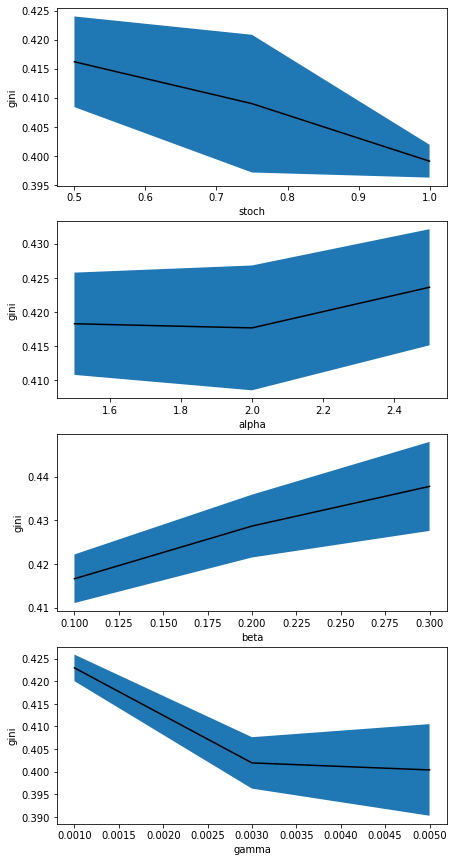

In [32]:
plot_all_vars(data, 'gini', problem)
plt.show()

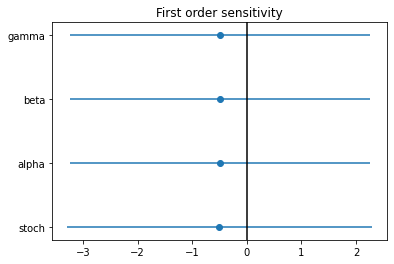

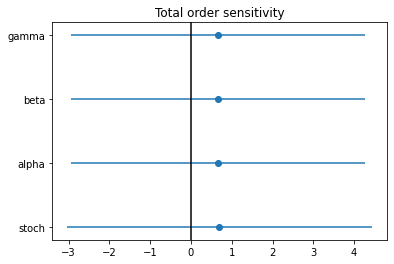

In [19]:
# FIrst order
plot_index(Si_pop, problem['names'], '1', 'First order sensitivity')
plt.show()

# Total order
plot_index(Si_pop, problem['names'], 'T', 'Total order sensitivity')
plt.show()